In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from PIL import Image
import time

# RUNNER

### IP solvers

#### compressed sensing

In [26]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import convolve2d
from PIL import Image

from linear_models.linear_models import linear_op
from Inverse_problem.solver import IP_solver
from linear_models.linear_models import linear
import utils.utils as utl

# variables
# denoiser_k = 29
pixels = 128
n = pixels**2
retention_ratio = 0.25
m = int(retention_ratio*n)
percent_of_holes = ((n - m) / n) * 100
K = int(50)
repeat = 1


image = np.array(Image.open('./phantom.png').convert('L').resize((pixels, pixels)), dtype=float)/255
sigma = 0
image = image + sigma*np.random.normal(size=image.shape)

# x_curr = op.leastsq_A(op.At(b), gamma=0.9)
# x_curr = np.zeros_like(image)
# for _ in range(7):
#     x_curr = x_curr - gamma* op.At(op.A(x_curr)-b)

print("retention ration: ", retention_ratio)
print("no. of measurements: ", m)

retention ration:  0.25
no. of measurements:  4096


retention ration 0.25
NO OF ITERATIONS =  1000
PSNR:  64.48
1.2819790051384952 -0.14719198421700572
minimum function value =  0.8020891566164033


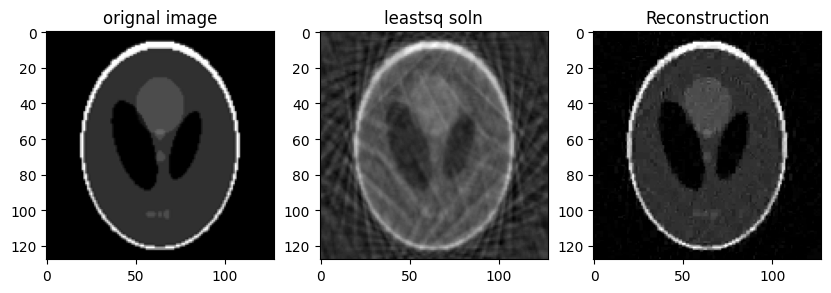

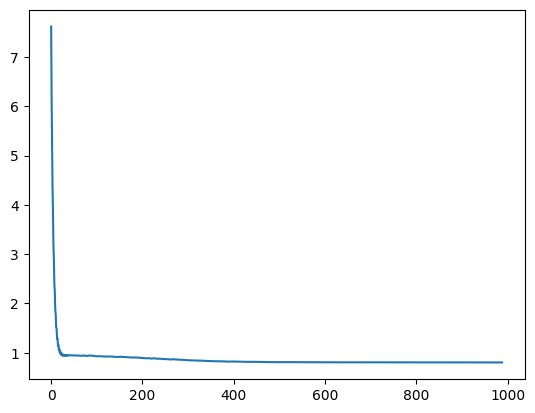

In [10]:
#FISTA/ISTA
# S = (utl.random_mask(image.shape[0], image.shape[1], percent_of_holes))
S = np.fft.fftshift(utl.star_mask(pixels=len(image), no_angles=20))
oper = {"m" : m, "S" : S}
op = linear(oper=oper, mode="cs-sf")

b = op.A(image)

params = utl.parameters(b, image,
                    mode = "cs-sf", oper = {"S" : S, "m" : m},
                    L = 0.77, lamda = 0.0001,
                    max_iter = 1000)

reg_para = utl.reg_params()
reg_para.wave = "haar"
reg_para.lvl = 3

sol = IP_solver(reg_para, params)
x_hat, function_vals = sol.FISTA()
print("retention ration", retention_ratio)
print("NO OF ITERATIONS = ", params.max_iter)
print("PSNR: ", utl.psnr(x_hat*255, image*255, 255))
print(np.max(x_hat), np.min(x_hat))
print("minimum function value = ", np.min(function_vals))

plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow((image), cmap="gray")
plt.title("orignal image")
plt.subplot(1, 3, 2)
x_curr = op.leastsq_A(op.At(b), gamma=0.9)
plt.imshow((x_curr), cmap="gray")
plt.title("leastsq soln")
plt.subplot(1, 3, 3)
plt.imshow(np.real(x_hat), cmap="gray", vmin=0, vmax=1)
plt.title("Reconstruction")
plt.show()

plt.plot(function_vals)
plt.show()

retention ration 0.25
NO OF ITERATIONS =  1000
PSNR:  63.52
0.8347054240034616 -1.1102230246251565e-16


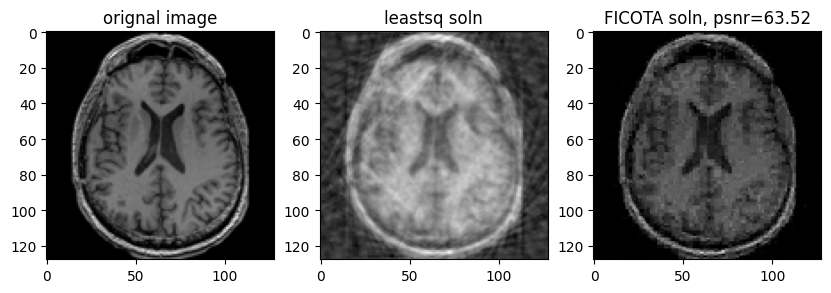

In [21]:
#FICOTA
# S = utl.random_mask(image.shape[0], image.shape[1], percent_of_holes)
S = np.fft.fftshift(utl.star_mask(pixels=len(image), no_angles=20))
oper = {"m" : m, "S" : S}
op = linear(oper=oper, mode="cs-sf")

b = op.A(image)

params = utl.parameters(b, image,
                    mode = "cs-sf", oper = {"S" : S, "m" : m},
                    L = 0.9, lamda = 0.0009,
                    max_iter = 1000)

reg_para = utl.reg_params()
reg_para.wave = "haar"
reg_para.lvl = 5

sol = IP_solver(reg_para, params)
x_hat = sol.FICOTA()
print("retention ration", retention_ratio)
print("NO OF ITERATIONS = ", params.max_iter)
print("PSNR: ", utl.psnr(x_hat, image))
print(np.max(x_hat), np.min(x_hat))

plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow((image), cmap="gray")
plt.title("orignal image")
plt.subplot(1, 3, 2)
x_curr = op.leastsq_A(op.At(b), gamma=0.9)
plt.imshow((x_curr), cmap="gray")
plt.title("leastsq soln")
plt.subplot(1, 3, 3)
plt.imshow(np.real(x_hat), cmap="gray", vmin=0, vmax=1)
plt.title(f"FICOTA soln, psnr={utl.psnr(x_hat, image)}")
plt.show()

retention ration 0.156494140625
NO OF ITERATIONS =  1000
PSNR:  70.21
0.8838765264399416 0.0
minimum function value =  0.0


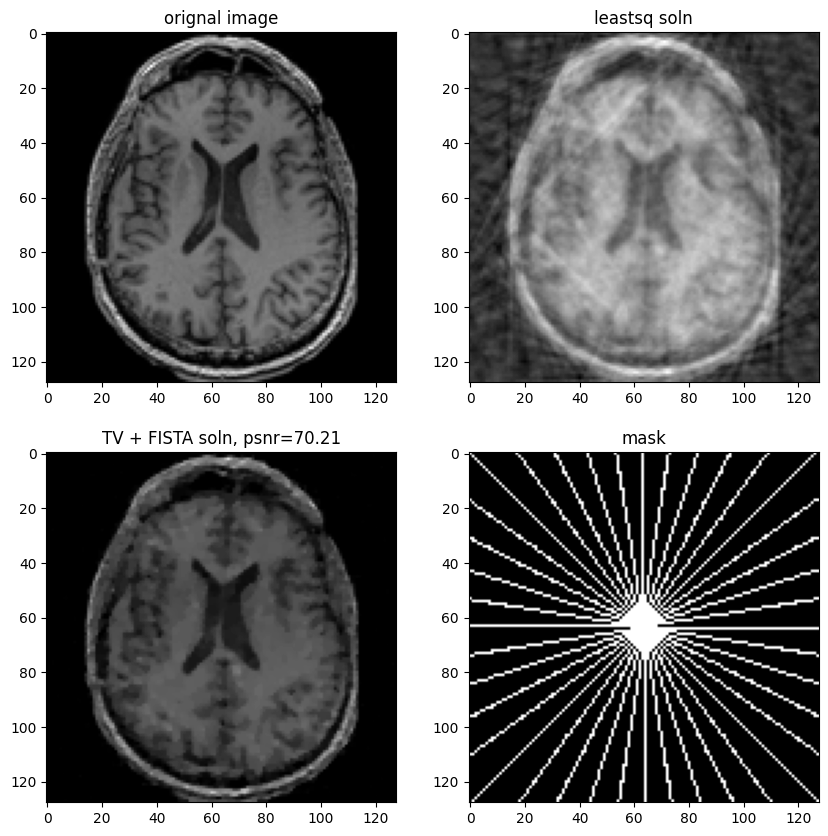

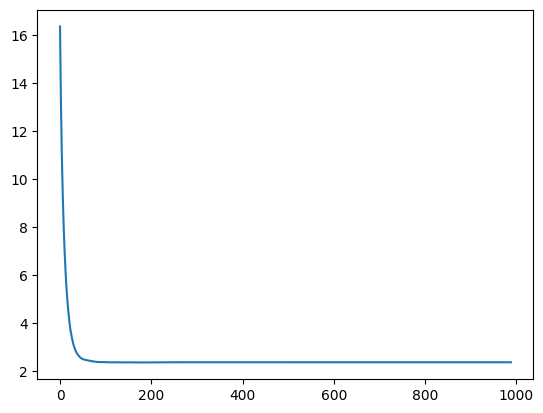

In [18]:
# # FISTA-FGP/ISTA-FGP
# S = utl.random_mask(image.shape[0], image.shape[1], percent_of_holes)
# S = S + np.fliplr(np.flipud(S))
# S[np.where(S>0)]=1
S = np.fft.fftshift(utl.star_mask(pixels=len(image), no_angles=20))
# S = utl.star_mask(pixels=len(image), no_angles=22)

# S[47:79, 47:79] = 1
oper = {"m" : m, "S" : S}
op = linear(oper=oper, mode="cs-sf")

b = op.A(image)

lamda = 0.0001
L = 1
params = utl.parameters(b, image,
                        mode = "cs-sf", oper = {"S" : S, "m" : m},
                        L = L, max_iter = 1000)

reg_para = utl.reg_params(lamda= lamda, 
                          proj_p="isotropic", iters=20)

sol = IP_solver(reg_para, params)
x_hat, function_vals = sol.FISTA_FGP()
print("retention ration", len(np.where(S>0)[0])/(pixels**2))
print("NO OF ITERATIONS = ", params.max_iter)
print("PSNR: ", utl.psnr(x_hat, image))
print(np.max(x_hat), np.min(x_hat))
print("minimum function value = ", np.min(x_hat))

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow((image), cmap="gray")
plt.title("orignal image")
plt.subplot(2, 2, 2)
x_curr = op.leastsq_A(op.At(b), gamma=0.9)
plt.imshow((x_curr), cmap="gray")
plt.title("leastsq soln")
plt.subplot(2, 2, 3)
plt.imshow(np.real(x_hat), cmap="gray", vmin=0, vmax=1)
plt.title(f"TV + FISTA soln, psnr={utl.psnr(x_hat, image)}")
plt.subplot(2, 2, 4)
plt.imshow(np.fft.fftshift(S), cmap="gray")
plt.title("mask")
plt.show()

plt.plot(function_vals)
plt.show()

retention ration 0.25
NO OF ITERATIONS =  30
PSNR:  40.44
0.5336123114333787 -0.18998711248512928


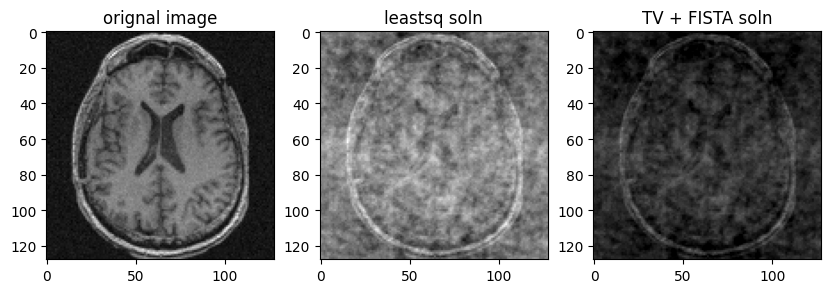

In [ ]:
#FISTA/ISTA
S = utl.random_mask(image.shape[0], image.shape[1], percent_of_holes)
oper = {"m" : m, "S" : S}
op = linear(oper=oper, mode="cs-sf")

b = op.A(image)

params = utl.parameters(b, image,
                    mode = "cs-sf", oper = {"S" : S, "m" : m},
                    L = 0.8, lamda = 0.0002,
                    max_iter = 30)

reg_para = utl.reg_params()
reg_para.wave = "haar"
reg_para.lvl = 5

sol = IP_solver(reg_para, params)
x_hat = sol.ISTA()
print("retention ration", retention_ratio)
print("NO OF ITERATIONS = ", params.max_iter)
print("PSNR: ", utl.psnr(x_hat, image))
print(np.max(x_hat), np.min(x_hat))

plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow((image), cmap="gray")
plt.title("orignal image")
plt.subplot(1, 3, 2)
x_curr = op.leastsq_A(op.At(b), gamma=0.9)
plt.imshow((x_curr), cmap="gray")
plt.title("leastsq soln")
plt.subplot(1, 3, 3)
plt.imshow(np.real(x_hat), cmap="gray", vmin=0, vmax=1)
plt.title("TV + FISTA soln")
plt.show()

retention ration 0.25
NO OF ITERATIONS =  30
PSNR:  40.44
0.5336123114333787 -0.18998711248512928


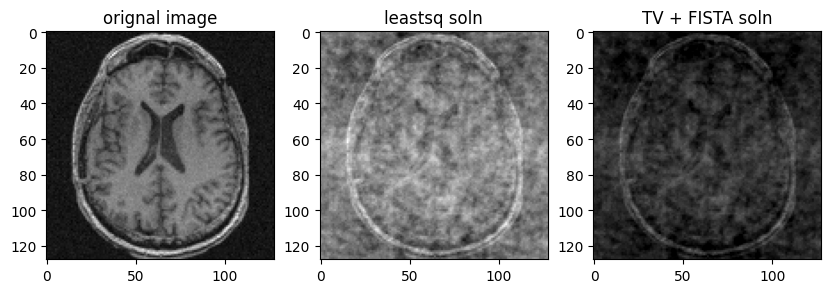

In [ ]:
#FISTA/ISTA
S = utl.random_mask(image.shape[0], image.shape[1], percent_of_holes)
oper = {"m" : m, "S" : S}
op = linear(oper=oper, mode="cs-sf")

b = op.A(image)

params = utl.parameters(b, image,
                    mode = "cs-sf", oper = {"S" : S, "m" : m},
                    L = 0.8, lamda = 0.0002,
                    max_iter = 30)

reg_para = utl.reg_params()
reg_para.wave = "haar"
reg_para.lvl = 5

sol = IP_solver(reg_para, params)
x_hat = sol.ISTA()
print("retention ration", retention_ratio)
print("NO OF ITERATIONS = ", params.max_iter)
print("PSNR: ", utl.psnr(x_hat, image))
print(np.max(x_hat), np.min(x_hat))

plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow((image), cmap="gray")
plt.title("orignal image")
plt.subplot(1, 3, 2)
x_curr = op.leastsq_A(op.At(b), gamma=0.9)
plt.imshow((x_curr), cmap="gray")
plt.title("leastsq soln")
plt.subplot(1, 3, 3)
plt.imshow(np.real(x_hat), cmap="gray", vmin=0, vmax=1)
plt.title("TV + FISTA soln")
plt.show()

retention ration 0.5
NO OF ITERATIONS =  20
PSNR:  50.83
0.5500941705841057 -0.10282495379523483


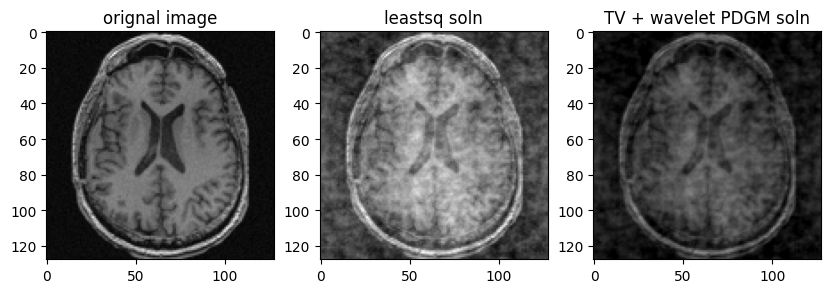

In [19]:
#PDGM
S = utl.random_mask(image.shape[0], image.shape[1], percent_of_holes)
oper = {"m" : m, "S" : S}
op = linear(oper=oper, mode="cs-sf")

b = op.A(image)

params = utl.parameters(b, image, max_iter = 20,
                        mode = "cs-sf", oper = {"S" : S, "m" : m}, radius=0,
                        L = 0.76)
params.taus = 0.01
params.thetas = 0.1

TV_para = utl.reg_params(proj_p="l1-term")

sol = IP_solver(TV_para, params)
x_star1 = sol.PDGM()
print("retention ration", retention_ratio)
print("NO OF ITERATIONS = ", params.max_iter)
print("PSNR: ", utl.psnr(x_star1, image))

print(np.max(x_star1), np.min(x_star1))
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow((image), cmap="gray")
plt.title("orignal image")
plt.subplot(1, 3, 2)
x_curr = op.leastsq_A(op.At(b), gamma=0.9)
plt.imshow((x_curr), cmap="gray")
plt.title("leastsq soln")
plt.subplot(1, 3, 3)
plt.imshow(x_star1, cmap="gray", vmin=0, vmax=1)
plt.title("TV + wavelet PDGM soln")
plt.show()

retention ration 0.156494140625
NO OF ITERATIONS =  1000
PSNR:  118.62


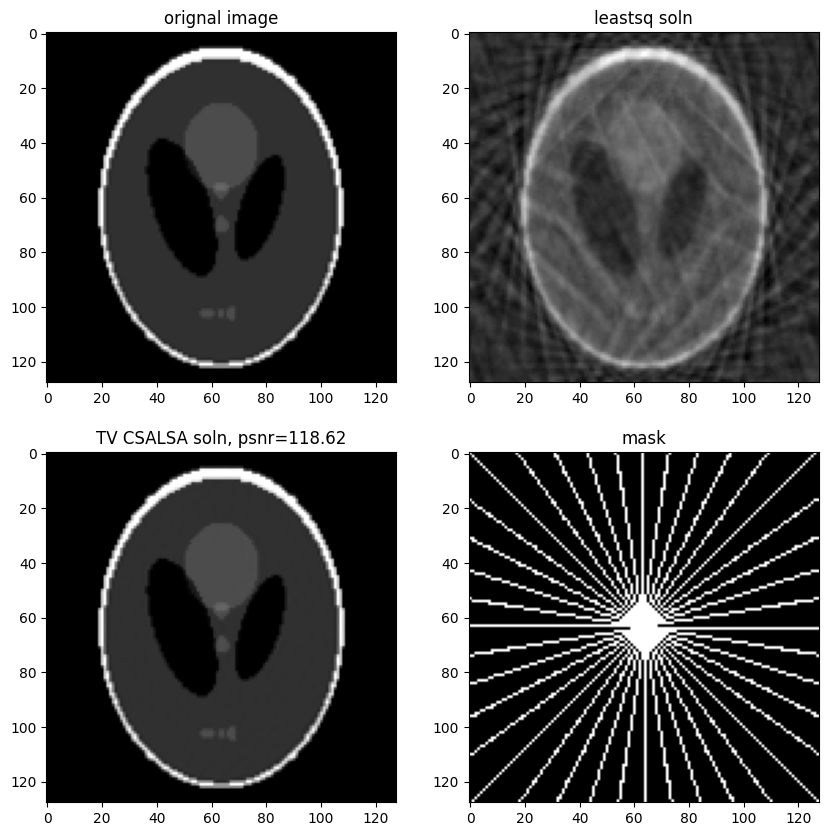

-2.298776358202609e-05 1.0000105449873806


In [27]:
#TV-CALSA

# S = utl.random_mask(image.shape[0], image.shape[1], percent_of_holes)
# S = S + np.fliplr(np.flipud(S))
# S[np.where(S>0)]=1
# S = utl.star_mask(pixels=len(image), no_angles=42)
S = np.fft.fftshift(utl.star_mask(pixels=len(image), no_angles=20))

oper = {"m" : m, "S" : S}
op = linear(oper=oper, mode="cs-sf")

b = op.A(image)

params = utl.parameters(b, image,
                    mode = "cs-sf", oper = {"S" : S, "m" : m}, radius=0, 
                    max_iter = 1000)
params.gamma = 1
TV_para = utl.reg_params(image=image, lamda=0.0001, 
                    iters=40,
                    u=1, l=0, 
                    proj_p="l1-term")

sol = IP_solver(TV_para, params)
x_hat = sol.TV_CSALSA()
print("retention ration", len(np.where(S>0)[0])/(pixels**2))
print("NO OF ITERATIONS = ", params.max_iter)
print("PSNR: ", utl.psnr(x_hat, image))

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow((image), cmap="gray")
plt.title("orignal image")
plt.subplot(2, 2, 2)
x_curr = op.leastsq_A(op.At(b), gamma=0.9)
plt.imshow((x_curr), cmap="gray")
plt.title("leastsq soln")
plt.subplot(2, 2, 3)
plt.imshow(np.real(x_hat), cmap="gray", vmin=0, vmax=1)
plt.title(f"TV CSALSA soln, psnr={utl.psnr(x_hat, image)}")
plt.subplot(2, 2, 4)
plt.imshow(np.fft.fftshift(S), cmap="gray")
plt.title("mask")
plt.show()
print(np.min(x_hat), np.max(x_hat))

#### super res

In [ ]:
image = np.array(Image.open('./cameraman.tif').convert('L'), dtype=float)/255
print("image: shape",image.shape)

print(f"image: max, min ={np.max(image), np.min(image)}" )
percent_of_holes = 40
size = 9
sigma = 4
ker = gaussian_kernel(size, sigma)
operator = {"operator" : ker, "res" : 4}
op = linear_op(mode= 'supr', oper = operator)
b = op.A(image)
b = b + np.random.normal(scale=0.01, size=image.shape)


In [ ]:
params = parameters(b, image,
                    mode = "supr", oper = operator, 
                    L = 1, 
                    max_iter=400, 
                    lamda = 0.0001)
TV_para = TV_params(image=image, lamda=0.0001, 
                    iters=10, 
                    u=1, l=0, 
                    proj_p="l1-term"
                    )
op = IP_solver(TV_para, params)
x_star = op.run_solver()
plt.imshow(x_star, cmap="gray")
plt.show

In [ ]:

mse = np.mean( (x_star - TV_para.image)**2 )
print("psnr = ",20 * np.log10( 1 / np.sqrt(mse)))
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(x_star, cmap="gray")
plt.title("Restored image")
plt.subplot(1, 3, 2)
plt.imshow(b, cmap="gray")
plt.title("Distorted image")
plt.subplot(1, 3, 3)
plt.imshow(TV_para.image, cmap="gray")
plt.title("Orignal image")
plt.show

#### inpainting

In [ ]:
image = np.array(Image.open('./cameraman.tif').convert('L'), dtype=float)/255
print("image: shape",image.shape)

print(f"image: max, min ={np.max(image), np.min(image)}" )
percent_of_holes = 40
mask = random_mask(image.shape[0], image.shape[1], percent_of_holes)
b = image + np.random.normal(scale=0.001, size=image.shape)
b = image*mask


In [ ]:
params = parameters(b, image,
                    mode = "inpnt", oper = mask, 
                    L = 1, 
                    max_iter=1000, 
                    lamda = 0.0001)
TV_para = TV_params(image=image, lamda=0.0001, 
                    iters=10, 
                    u=1, l=0, 
                    proj_p="l1-term"
                    )
op = IP_solver(TV_para, params)
x_star = op.run_solver()
plt.imshow(x_star, cmap="gray")
plt.show

In [ ]:

mse = np.mean( (x_star - TV_para.image)**2 )
print("psnr = ",20 * np.log10( 1 / np.sqrt(mse)))
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(x_star, cmap="gray")
plt.title("Restored image")
plt.subplot(1, 3, 2)
plt.imshow(b, cmap="gray")
plt.title("Distorted image")
plt.subplot(1, 3, 3)
plt.imshow(TV_para.image, cmap="gray")
plt.title("Orignal image")
plt.show

#### debluring

In [ ]:
image = np.array(Image.open('./cameraman.tif').convert('L'), dtype=float)/255
print("image: shape",image.shape)

print(f"image: max, min ={np.max(image), np.min(image)}" )
size = 9
sigma = 4
ker = gaussian_kernel(size, sigma)
b = np.pad(image, size//2, mode = 'reflect')
b = convolve2d(b, ker, 'valid')
b = b + np.random.normal(scale=0.001, size=image.shape)

In [ ]:
params = parameters(b, image,
                    mode = "blur", oper = ker, 
                    L = 1, 
                    max_iter=100, 
                    lamda = 0.0001)
TV_para = TV_params(image=image, lamda=0.0001, 
                    iters=10, 
                    u=1, l=0, 
                    proj_p="l1-term"
                    )
op = IP_solver(TV_para, params)
x_star = op.run_solver()
plt.imshow(x_star, cmap="gray")
plt.show

In [ ]:

mse = np.mean( (x_star - TV_para.image)**2 )
print("psnr = ",20 * np.log10( 1 / np.sqrt(mse)))
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(x_star, cmap="gray")
plt.title("Restored image")
plt.subplot(1, 3, 2)
plt.imshow(b, cmap="gray")
plt.title("Distorted image")
plt.subplot(1, 3, 3)
plt.imshow(TV_para.image, cmap="gray")
plt.title("Orignal image")
plt.show

#### De-noising

In [3]:
# image = np.array(Image.open('./cameraman.tif').convert('L'), dtype=float)/255
image = np.array(Image.open('./cameraman.tif').convert('L'), dtype=float)/255
print("image: shape",image.shape)
print(f"image: max, min ={np.max(image), np.min(image)}" )
noise = 0.05
b = image + np.random.normal(scale=noise, size=image.shape)

image: shape (256, 256)
image: max, min =(0.9921568627450981, 0.027450980392156862)


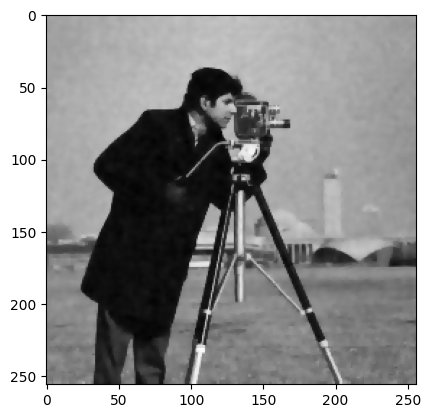

In [6]:
TV_para = TV_params(image=image, lamda=0.05, 
                    iters=10, 
                    u=1, l=0, 
                    proj_p="l1-term"
                    )
op = prox_TV(TV_para)
x_star = op.prox(b)

plt.imshow(x_star, cmap="gray")

MSE =  0.0011121075366992308
psnr =  77.66933576915918


<function matplotlib.pyplot.show(close=None, block=None)>

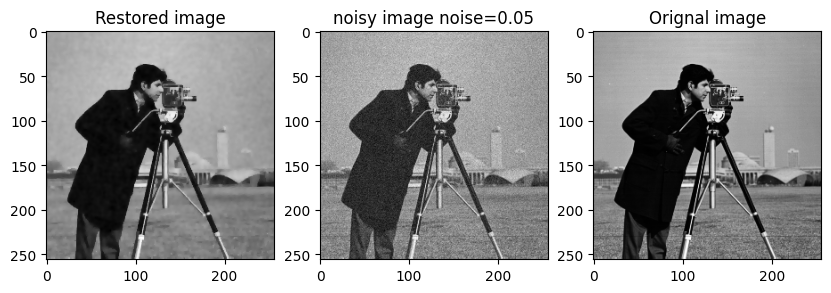

In [7]:

mse = np.mean( (x_star - TV_para.image)**2 )
print("MSE = ", mse)
print("psnr = ",20 * np.log10( 255 / np.sqrt(mse)))
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(x_star, cmap="gray")
plt.title("Restored image")
plt.subplot(1, 3, 2)
plt.imshow(b, cmap="gray")
plt.title(f"noisy image noise={noise}")
plt.subplot(1, 3, 3)
plt.imshow(TV_para.image, cmap="gray")
plt.title("Orignal image")
plt.show

### Stochastic IP solvers

#### MYULA

In [ ]:
size=256
image = np.array(Image.open('cameraman.tif').convert('L').resize((size,size)), dtype=float)/255
print("image: shape",image.shape)

print(f"image: max, min ={np.max(image), np.min(image)}" )
size = 9
sigma = 4
ker = gaussian_kernel(size, sigma)
# size = 9
# ker = np.ones((size,size), dtype=float)/(size**2)
dist_I = np.pad(image, size//2, mode = 'reflect')
dist_I = convolve2d(dist_I, ker, 'valid')

beta = 0.03
sigma = 0.47/255
Lf = 1/(sigma**2)
print(sigma)


b = dist_I + np.random.normal(scale=sigma, size=image.shape)
plt.imshow(b, cmap="gray")

In [ ]:
zeta, zhi = 1,1
# lamda = 0.9
lamda = 1/Lf*zeta
# gamma = 0.1
gamma = 1/(5*Lf)*zhi

print("gamma:", gamma)
print("gamma/lamda:", gamma/lamda)

params = SIP_parameters(
    b, image,
    mode = "blur", oper = ker, 
    # mode = "I", oper = None, 
    L = 1, 
    max_iters=10000, 
    lamda = lamda,
    gamma=gamma,
    sigma=sigma
    )
TV_para = TV_params(
    image=image, lamda=lamda*beta, 
    iters=10,
    u=1, l=0, 
    proj_p="l1-term"
    )
pic_verbose = 1
op = SIP_solver(TV_para, params, pic_verbose)
x_star = op.run_solver()
mse_b = np.mean( (x_star - params.b)**2 )
mse_i = np.mean( (x_star - params.image)**2 )
print(np.min(x_star))
print(np.max(x_star))
print(f"(b)mse = {mse_b}, (image)mse = ",mse_i)
plt.imshow(x_star, cmap="gray")
plt.show()

In [ ]:

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow(TV_para.image, cmap="gray")
plt.title(f"Orignal image, PSNR = {round(20 * np.log10( 1 / np.sqrt(mse_i)), 2)}")
plt.subplot(2, 2, 2)
plt.imshow(b, cmap="gray")
plt.title(f"Distorted image({sigma}), PSNR = {round(20 * np.log10( 1 / np.sqrt(mse_b)), 2)}")
plt.subplot(2, 2, 3)
plt.imshow(x_star, cmap="gray")
plt.title("Restored image")
plt.subplot(2, 2, 4)
plt.imshow(TV_para.image-x_star, cmap="gray")
plt.title(f"noise, std = {round(np.std(TV_para.image-x_star), 2)}")
plt.show()
# print(np.max(TV_para.image-x_star))
# print(np.min(TV_para.image-x_star))

# Rough

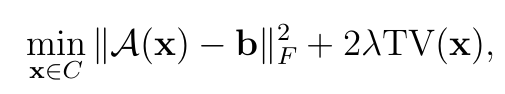

In [ ]:
def check_F_val(zk, xk_minus_1, params):
    Ax = linear.A(xk_minus_1)
    Az = linear.A(zk)
    tv_x = TV(xk_minus_1)
    tv_z = TV(zk)
    Fx = np.linalg.norm(Ax - params.b)**2 + 2 * params.lamda * tv_x
    Fz = np.linalg.norm(Az - params.b)**2 + 2 * params.lamda * tv_z
    if Fx>Fz:
        return zk
    else:
        return xk_minus_1

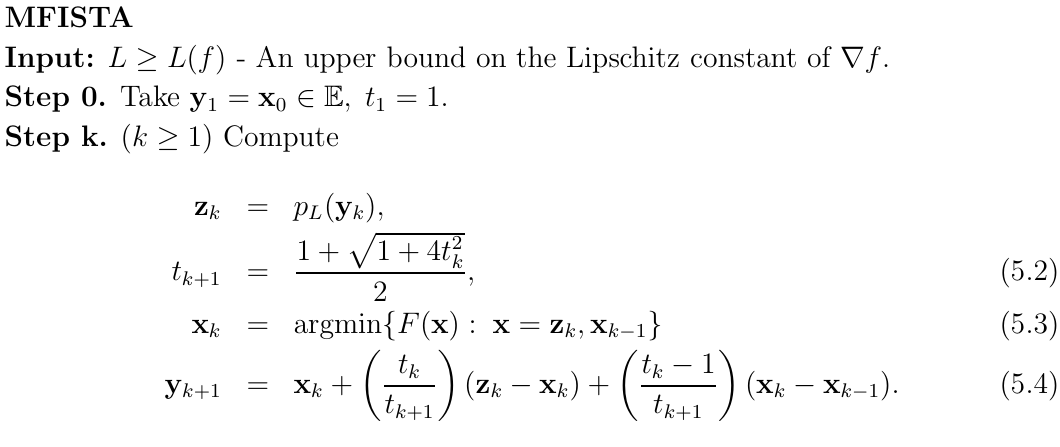

In [ ]:
def MFISTA(params):
    xk_minus_1 = yk = np.random.np.random.normal(scale=0.1, size=params.x.shape)
    tk = 1
    prox_op = prox_TV(TV_para)


    for i in range(params.iters):
        zk = prox_op.prox(yk)
        tk_plus_1 = (1 + np.sqrt(1 + 4 * (tk**2)))/2
        xk = check_F_val(zk, xk_minus_1)
        yk_plus_1 = xk + (tk / tk_plus_1)*(zk - xk) + ((tk - 1) / tk_plus_1) * (xk - xk_minus_1)

        yk = yk_plus_1
        xk_minus_1 = xk

In [ ]:
# def FISTA(params, op):
#   x_prev = params.x0
#   y_k = x_prev
#   t_k = 1
#   Lk_1 = params.L0
  
#   MSE_FISTA = []
#   MAE_FISTA = []
#   maxAE_FISTA = []
#   f_val = []
#   L_FISTA = []
  
#   for i in range(params.max_iter):
    
#     # get Lipchitz.
#     Lk = get_lipchitz(params, Lk_1, x_prev, op)
#     # prox of yk.
#     x_k = p(params, Lk, y_k, op)
#     t_kp1 = (1+np.sqrt(1 + 4 * t_k**2))/2
    
#     # get y_k+1
#     alpha = -(t_k - 1) / t_kp1
#     y_k = add_wav_coff(1 - alpha, x_k , alpha, x_prev, op)

#     # append stats
#     f_val.append(feval(params, x_k, op))
#     L_FISTA.append(Lk)
#     MSE_FISTA.append(np.mean((op.W.inverse_wave_trasf(x_k) - params.image)**2))
#     MAE_FISTA.append(np.mean(np.abs(op.W.inverse_wave_trasf(x_k) - params.image)))
#     maxAE_FISTA.append(np.max(np.abs(op.W.inverse_wave_trasf(x_k) - params.image)))

#     # update for next iter.
#     x_prev = x_k
#     t_k = t_kp1
#     Lk_1=Lk

#     if (i+1)%50==0:
#       plt.figure(figsize=(5,5))
#       plt.imshow(op.W.inverse_wave_trasf(x_k), cmap="gray", vmin=0,vmax=1)
#       plt.show()
#       # plt.title(f"reconstruction lamda = {lamdaList[i]}")
#       # plt.subplot(1,2,2)
#       # plt.imshow(b, cmap="gray", vmin=0,vmax=1)
#       # plt.title(f"loss = {percentlist[i]}%")
#   reconsFISTA  = x_k

#   return MSE_FISTA, MAE_FISTA, maxAE_FISTA, L_FISTA, f_val, reconsFISTA

# shortProj

In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.signal import convolve2d

def grad_f(x, b, op):
    # input: x- wavelet coeff.
    #        L- Lipchitz const.
    # out: grad_f(.) = At.A(.) - At(b)
    grad = op.At(op.A(x)) - op.At(b)
    return np.real(grad)

def ideal_LPF(I, radius):
    rows, cols = I.shape
    u = np.arange(-cols//2, cols//2)
    v = np.arange(-rows//2, rows//2)
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    H = fftshift(np.double(D <= radius))

    F = fft2(I)
    G = F * H
    filtered_image = ifft2(G)
    return np.real(filtered_image)

def psnr(x, image):
    mse = np.mean((x-image)**2)
    return round(10*np.log(1/mse),2)

def random_mask(height, width, percent_of_holes):
    percentage = 100 - percent_of_holes
    num_pixels = height * width
    num_ones = int(num_pixels * percentage / 100)
    indices = np.random.choice(num_pixels, num_ones, replace=False)
    matrix = np.zeros((height, width), dtype=int)
    matrix.flat[indices] = 1
    return matrix

def gaussian_kernel(size, sigma=1):
    # Create a grid of coordinates.
    x = np.linspace(-(size - 1) / 2, (size - 1) / 2, size)
    y = np.linspace(-(size - 1) / 2, (size - 1) / 2, size)
    xv, yv = np.meshgrid(x, y)
    # Calculate the Gaussian function.
    kernel = np.exp(-(xv ** 2 + yv ** 2) / (2 * sigma ** 2))
    # Normalize the kernel.
    kernel = kernel / np.sum(kernel)
    return kernel


In [18]:
def W_(b, sigmas, repeat, op, op_H=None, size=29, gamma = 0.8, DN=None):

    xk = np.zeros_like(image)
    print('denoising')
    for sigma in sigmas:
        for _ in range(repeat):
            # grad = op(xk) - b
            # grad = op_H(grad)

            # data step
            xk_plus_1 = xk
            for _ in range(7):
                xk_plus_1 = xk_plus_1 - gamma* op.At(op.A(xk_plus_1)-b)
            # xk_plus_1 = op.leastsq_A(op.At(b), gamma=gamma)

            # denoising
            if DN == None:
                ker = gaussian_kernel(size, sigma)
                xk_plus_1 = np.pad(xk_plus_1, size//2, mode = 'wrap')
                xk_plus_1 = convolve2d(xk_plus_1, ker, 'valid')
            else:
                xk_plus_1 = DN.prox(xk_plus_1)

            xk = xk_plus_1
        # plt.imshow(xk, cmap="gray")
        # plt.show()
    return xk

In [19]:
from linear_models.linear_models import linear

# variables
# denoiser_k = 29
pixels = 128
n = pixels**2
retention_ratio = 0.3
m = int(retention_ratio*n)
percent_of_holes = ((n - m) / n) * 100
K = int(50)
repeat = 1
gamma = 1
image = np.array(Image.open('./brain.png').convert('L').resize((pixels, pixels)), dtype=float)/255
image = image + np.random.normal(scale=5/255, size=image.shape)


## **leastsq soln**

retention ration 0.3
psnr =  32.17


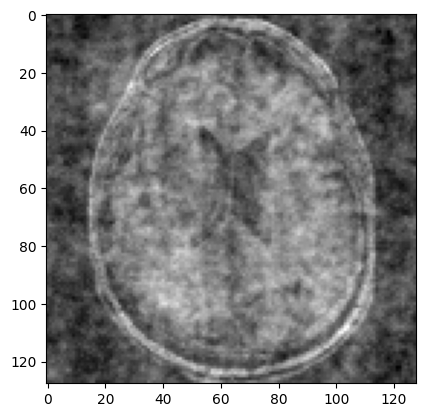

In [17]:
# S = random_mask(image.shape[0], image.shape[1], percent_of_holes)
oper = {"m" : m, "S" : S}
lin_op = linear(oper=oper, mode="cs-sf")

b = lin_op.A(image)

x_curr = lin_op.leastsq_A(lin_op.At(b), gamma=0.6)
plt.imshow((x_curr), cmap="gray")
print("retention ration", retention_ratio)
print("psnr = ", psnr(x_curr, image))

retention ration 0.3
psnr =  34.35


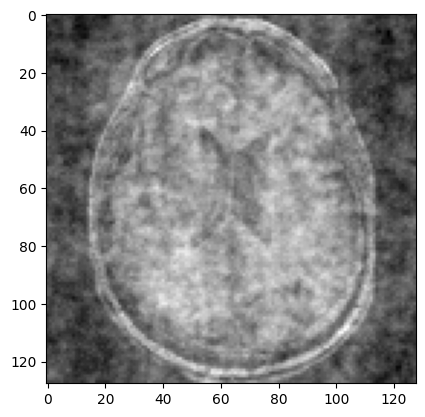

In [18]:
x_curr = np.zeros_like(image)
for _ in range(30):
    x_curr = x_curr - gamma* lin_op.At(olin_opp.A(x_curr)-b)
plt.imshow((x_curr), cmap="gray")
print("retention ration", retention_ratio)
print("psnr = ", psnr(x_curr, image))

## **TV**

In [20]:
from regularization.TV import prox_TV

class TV_params:
    def __init__(self, image, lamda, iters, l, u, proj_p):
        self.image = image
        self.lamda = lamda
        self.iters = iters
        self.l = l
        self.u = u
        self.proj_p = proj_p          # "isotropic" , "l1-term"

retention ration =  0.3
NO OF ITERATIONS =  200
denoising


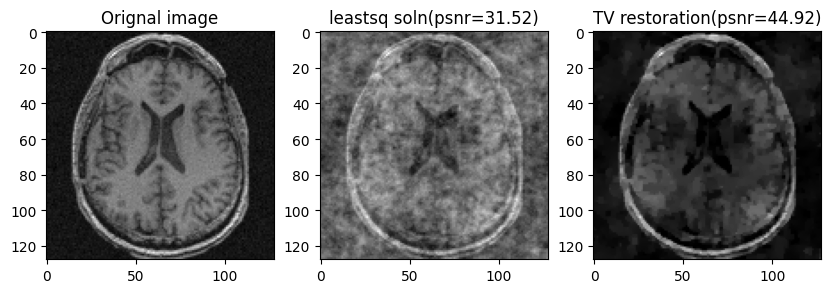

In [39]:
# S = random_mask(image.shape[0], image.shape[1], percent_of_holes)
oper = {"m" : m, "S" : S}
lin_op = linear(oper=oper, mode="cs-sf")

b = lin_op.A(image)

TV_para = TV_params(image=image, lamda=0.007, 
                    iters=10, 
                    u=1, l=0, 
                    proj_p="l1-term")
DN = prox_TV(TV_para)
print("retention ration = ", retention_ratio)
sigmas = np.zeros((200,))
# sigmas = np.geomspace(2, 0.001, K)
# sigmas[(np.geomspace(1, K, K//5)-1).astype(int)]
print("NO OF ITERATIONS = ", len(sigmas))
xk = W_(b, sigmas, repeat, lin_op, gamma=0.3, DN= DN)
# xk = W_(b, sigmas, repeat, lin_op, gamma=gamma, DN= None)

x_curr = np.zeros_like(image)
for _ in range(30):
    x_curr = x_curr - gamma* lin_op.At(lin_op.A(x_curr)-b)

plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Orignal image")
plt.subplot(1, 3, 2)
plt.imshow((x_curr), cmap="gray")
plt.title(f"leastsq soln(psnr={psnr(x_curr, image)})")
plt.subplot(1, 3, 3)
plt.imshow(xk, cmap="gray")
plt.title(f"TV restoration(psnr={psnr(xk, image)})")
plt.show()

In [ ]:

# sigmas = np.geomspace(2, 0.001, 100)
# psnr_val = []
# print("Average PSNR over 25 results")
# print("NO OF ITERATIONS = ", len(sigmas))
# for _ in range(1):
#     xk = W_(b, sigmas, repeat, op, gamma=gamma)
#     psnr_val.append(psnr(xk, image))
# print("avg PSNR(Gp(2-0.001) samples) = ", np.mean(psnr_val))

# plt.figure(figsize=(10,10))
# plt.subplot(1, 3, 1)
# plt.imshow(image, cmap="gray")
# plt.title("Orignal image")
# plt.subplot(1, 3, 2)
# plt.imshow(op.At(b), cmap="gray")
# plt.title(f"Distorted image(psnr={psnr(op.At(b), image)})")
# plt.subplot(1, 3, 3)
# plt.imshow(xk, cmap="gray")
# plt.title(f"Restored image(psnr={psnr(xk, image)})")
# plt.show()

# sigmas = np.geomspace(2, 0.001, 20)
# psnr_val = []
# print("NO OF ITERATIONS = ", len(sigmas))
# for _ in range(1):
#     xk = W_(b, sigmas, repeat, op, gamma=gamma)
#     psnr_val.append(psnr(xk, image))
# print("avg PSNR(Gp(2-0.001) samples) = ", np.mean(psnr_val))

# plt.figure(figsize=(10,10))
# plt.subplot(1, 3, 1)
# plt.imshow(image, cmap="gray")
# plt.title("Orignal image")
# plt.subplot(1, 3, 2)
# plt.imshow(op.At(b), cmap="gray")
# plt.title(f"Distorted image(psnr={psnr(op.At(b), image)})")
# plt.subplot(1, 3, 3)
# plt.imshow(xk, cmap="gray")
# plt.title(f"Restored image(psnr={psnr(xk, image)})")
# plt.show()


In [29]:
pixels = 128
n = pixels**2
retention_ratio = 0.3
m = int(retention_ratio*n)
percent_of_holes = ((n - m) / n) * 100
gamma = 0.5

image = np.array(Image.open('./brain.png').convert('L').resize((pixels, pixels)), dtype=float)/255
image = image + np.random.normal(scale=5/255, size=image.shape)

# S = random_mask(image.shape[0], image.shape[1], percent_of_holes)
oper = {"m" : m, "S" : S}
lin_op = linear(oper=oper, mode="cs-sf")

b = lin_op.A(image) 
print("retention ration", retention_ratio)

gammas = np.linspace(0.1, 2, 200)
psnr_vals = []
for g in gammas:
    x_curr = np.zeros_like(image)
    x_curr = lin_op.leastsq_A(lin_op.At(b), gamma=g)
    psnr_vals.append(psnr(x_curr, image))
    # plt.imshow((x_curr), cmap="gray")
    # plt.title(f'{g}, {psnr_vals[-1]}')
    # plt.show()

# for _ in range(100):
#     x_curr = x_curr - gamma* lin_op.At(lin_op.A(x_curr)-b)

retention ration 0.3
